# Уравнение теплопроводности 2+1

Решите начально-краевую задачу для двумерного уравнения теплопроводности
$$
u_t = 2 (u_{xx} + u_{yy}) + e^t \cos(\frac{\pi x}{2}) \sin(\frac{\pi y}{2}), x \in [0, 1], y \in [0, 1], t > 0 \\
u\Big|_{t=0} = 1 + xy \\
u\Big|_{x=0} = 1 + \frac{(e^t - e^{-\pi^2 t})}{1 + \pi^2} \sin(\frac{\pi y}{2}), \quad u\Big|_{x=1} = 1 + y \\
u\Big|_{y=0} = 1, \quad u\Big|_{y=1} = 1 + x + \frac{(e^t - e^{-\pi^2 t})}{1 + \pi^2} \cos(\frac{\pi x}{2})
$$

Точное решение задачи:
$$
u(x, y, t) = 1 + xy + \frac{(e^t - e^{-\pi^2 t})}{1 + \pi^2} \cos(\frac{\pi x}{2}) \sin(\frac{\pi y}{2})
$$

*Решение:*

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Зададим условия задачи:

In [2]:
f = lambda x1, x2, t: np.exp(t) * np.cos((np.pi * x1)/2) * np.sin((np.pi * x2)/2)

u_0 = lambda x1, x2: 1 + x1 * x2

u_x10 = lambda x2, t: 1 + (np.exp(t) - np.exp(-np.pi**2 * t))/(1 + np.pi**2) * np.sin((np.pi * x2)/2)
u_x11 = lambda x2, t: 1 + x2

u_x20 = lambda x1, t: 1
u_x21 = lambda x1, t: 1 + x1 + (np.exp(t) - np.exp(-np.pi**2 * t))/(1 + np.pi**2) * np.cos((np.pi * x1)/2)

Точное решение:

In [3]:
u = lambda x1, x2, t: 1 + x1*x2 + (np.exp(t) - np.exp(-np.pi**2 * t))/(1 + np.pi**2) * np.cos((np.pi * x1)/2) * np.sin((np.pi * x2)/2)

Зададим сетку:

In [4]:
h = 1e-2
tau = 1e-2
K = 2

x = np.arange(0, 1+h, h)
t = np.arange(0, K+tau, tau)
half_t = np.arange(tau/2, K, tau)

In [5]:
X1_3d, X2_3d, T_3d = np.meshgrid(x, x, t, indexing='ij')

Создадим переменную для функции-аппроксимации, а также переменную для её значений на полуцелых слоях:

In [6]:
y = np.zeros_like(X1_3d)
y_half_layer = np.zeros_like(X1_3d[:,:,:-1])

Заполним начальные условия для аппроксимации:

In [7]:
y[:,:,0] = u_0(*np.meshgrid(x, x, indexing='ij'))

y[0,:,:] = u_x10(*np.meshgrid(x, t, indexing='ij'))
y[-1,:,:] = u_x11(*np.meshgrid(x, t, indexing='ij'))

y[:,0,:] = u_x20(*np.meshgrid(x, t, indexing='ij'))
y[:,-1,:] = u_x21(*np.meshgrid(x, t, indexing='ij'))

Для аппроксимации на полуцелых слоях:

In [8]:
y_half_layer[0, :, :] = u_x10(*np.meshgrid(x, half_t, indexing='ij'))
y_half_layer[-1, :, :] = u_x11(*np.meshgrid(x, half_t, indexing='ij'))

y_half_layer[:, 0, :] = u_x20(*np.meshgrid(x, half_t, indexing='ij'))
y_half_layer[:, -1, :] = u_x21(*np.meshgrid(x, half_t, indexing='ij'))

Определим разностные операторы взятия второй производной:

In [9]:
# на полуцелых слоях по первой переменной:
def Lam1_half(i, j, n):
    return (y_half_layer[i+1,j,n] - 2 * y_half_layer[i,j,n] + y_half_layer[i-1,j,n]) / h**2

# на обычных слоях по второй переменной:
def Lam2(i, j, n):
    return (y[i,j+1,n] - 2 * y[i,j,n] + y[i,j-1,n]) / h**2

Реализуем продольно-поперечную схему:

In [10]:
from scipy.linalg import solve_banded

def ADI_scheme(grid, half_grid, x, h=h, tau=tau):
    '''
    grid : 3d массив сеточной функции-аппроксимации
    half_grid: 3d массив сеточной функции-аппроксимации на полуцелых слоях
    x: 1d массив независимой переменной. Подразумевается, что сетка является квадратной по пространству.
    h, tau : шаги по пространству и времени
    '''
    n_X = grid.shape[0]
    n_T = grid.shape[2]

    # определим вид трёхдиагональной матрицы
    # так как сетка квадратная по пространству, то матрица на обоих шагах будет одинаковой
    ab = np.zeros((3, n_X - 2))
    gamma = h**2 / tau

    ab[0, 1:] = 1
    ab[1, :] = -(2 + gamma)
    ab[2, :-1] = 1

    # цикл по слоям времени
    for n in range(n_T - 1):
        # переход на полуцелый слой, цикл по второй координате:
        for j in range(1, n_X - 1):
        
            # правая часть системы уравнений:
            b = -(gamma * grid[1:-1, j, n] + h**2 * f(x[1:-1], x[j], half_t[n]) / 2 + h**2 * Lam2(range(1, n_X - 1), j, n))
            b[0] -= half_grid[0, j, n]
            b[-1] -= half_grid[-1, j, n]

            # значения на полуцелом слое:
            half_grid[1:-1, j, n] = solve_banded((1,1), ab, b)
        
        # переход на слой n+1, цикл по первой координате:
        for i in range(1, n_X - 1):

            # правая часть системы уравнений:
            b = -(gamma * half_grid[i, 1:-1, n] + h**2 * f(x[i], x[1:-1], half_t[n]) / 2 + h**2 * Lam1_half(i, range(1, n_X - 1), n))
            b[0] -= grid[i, 0, n+1]
            b[-1] -= grid[i, -1, n+1]

            # значения на слое n+1:
            grid[i, 1:-1, n+1] = solve_banded((1,1), ab, b)
    
    return grid

Аппроксимируем функцию:

In [11]:
y = ADI_scheme(y, y_half_layer, x)

Посчитаем значения истинной функции на сетке:

In [12]:
u_val = u(X1_3d, X2_3d, T_3d)

Посчитаем C1-норму разности аппроксимации и истинной функции:

In [13]:
np.max(np.abs(u_val - y))

8.577594296776958e-05

Нарисуем графики для заданных t:

In [14]:
def plot_3d_subplots(X1, X2, t_space, t, u_val, y_val): 
    ind, = np.where(t_space == t)

    fig = plt.figure(figsize=(20, 8))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    U = np.squeeze(u_val[:,:, ind])
    ax.plot_surface(X1, X2, U)
    ax.view_init(30, 150)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('u')
    ax.set_title('Истинная функция')

    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.plot_surface(X1, X2, np.squeeze(y_val[:,:, ind]))
    ax.view_init(30, 150)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('y')
    ax.set_title('Аппроксимация')

    plt.suptitle(f"Графики функций при t = {t}", fontsize=16)

    plt.show()

In [15]:
X1_2d, X2_2d = np.meshgrid(x, x, indexing='ij')

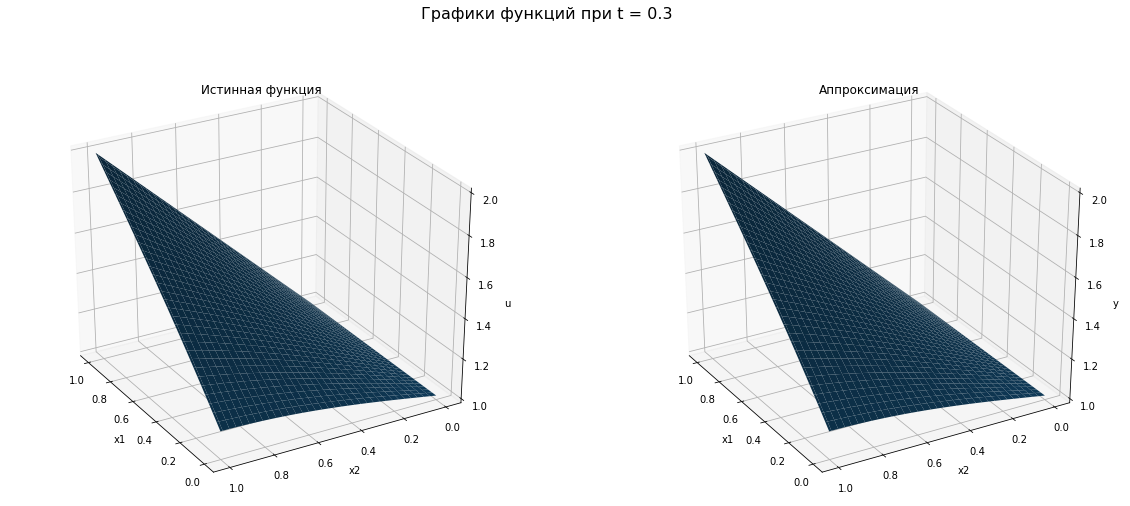

In [16]:
plot_3d_subplots(X1_2d, X2_2d, t, 0.3, u_val, y)

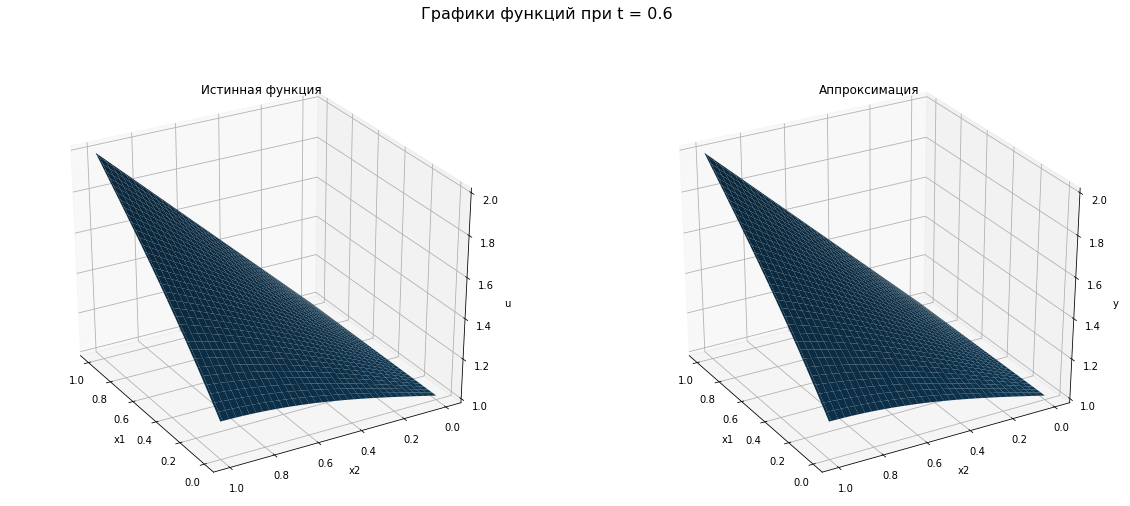

In [17]:
plot_3d_subplots(X1_2d, X2_2d, t, 0.6, u_val, y)

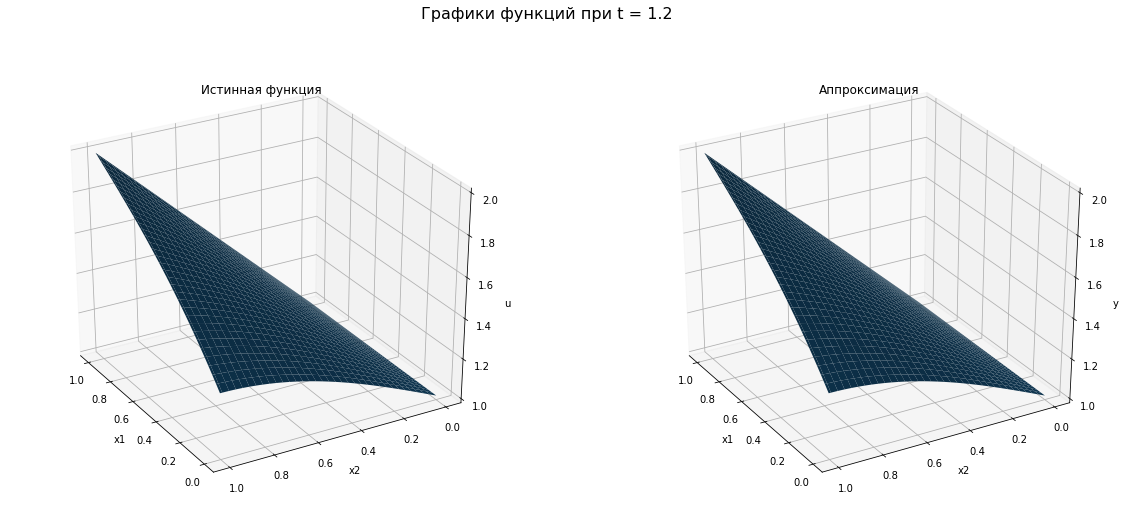

In [18]:
plot_3d_subplots(X1_2d, X2_2d, t, 1.2, u_val, y)